---
title: "Fine tuning a VLM using TRL and Hugging Face Jobs"
description: "This tutorial covers the process of fine-tuning a Vision-Language Model (VLM) using the TRL library and Hugging Face Jobs for creating a specialized model."
author: "Daniel van Strien"
categories: ["huggingface", "uv-scripts", "vlm", "hf Jobs"]
image: https://github.com/davanstrien/blog/blob/main/posts/2025/iconclass-vlm-sft/assets/iconclass-post-visual.png?raw=true
twitter-card:
  title: "Fine-tuning a VLM for art history with TRL and HF Jobs"
  description: "Learn how to fine-tune vision-language models for specialized tasks like Iconclass metadata generation using TRL's VLM support and Hugging Face Jobs - no local GPU required!"
  image: https://github.com/davanstrien/blog/blob/main/posts/2025/iconclass-vlm-sft/assets/iconclass-post-visual.png?raw=true
  card-style: summary_large_image
open-graph:
  title: "Fine-tuning a VLM for art history with TRL and HF Jobs"
  description: "Learn how to fine-tune vision-language models for specialized tasks like Iconclass metadata generation using TRL's VLM support and Hugging Face Jobs - no local GPU required!"
  image: https://github.com/davanstrien/blog/blob/main/posts/2025/iconclass-vlm-sft/assets/iconclass-post-visual.png?raw=true
toc-depth: 3
toc: true
---

## Fine tuning a Qwen model to assign art history metadata 

Open VLMs have become increasingly competitive with proprietary models but all models (including proprietary) can face challenges in adapting to specific domains like art history. Using supervised fine tuning can help improve a model's performance on specialized tasks like this.

Recently, [TRL](https://github.com/huggingface/trl) a very popular library for training transformers models using a variety of training approaches added support for supervised fine tuning of VLMs! Combined with the recently released HF Jobs service we can use TRL to do SFT on a VLM with no local GPU setup required!

### Iconclass metadata

In this post, I'll use the example of using SFT to train a model to generate Iconclass metadata for artworks.

> The Iconclass system has a history reaching back into the 1940’s when Henri van de Waal began to develop ideas for a universal classification for the subject matter of works of art. [^1]

The Iconclass metadata system consists of a hierarchical structure of categories and subcategories, allowing for a detailed description of the content of artworks. The top level categories are:

```
0 · Abstract, Non-representational Art
1 · Religion and Magic
2 · Nature
3 · Human Being, Man in General
4 · Society, Civilization, Culture
5 · Abstract Ideas and Concepts
6 · History
7 · Bible
8 · Literature
9 · Classical Mythology and Ancient History
```

Within these are more specific subcategories that allow for even greater detail in the classification of artworks (you can find more detailed info on the system below)

::: {.callout-note collapse="true"}

## More detail on how the Iconclass system works

Underneath each main category, there are numerous subcategories that further refine the classification. 

For example under 3 (Human Being, Man in General), we find subcategories such as:

![](https://github.com/davanstrien/blog/blob/69a4371424e1ec7d1c446373ab75825b4baaf334/posts/2025/iconclass-vlm-sft/assets/iconclass-level-1.png?raw=true)

We then move down the hierarchy levels we see more specific subcategories:

![](https://github.com/davanstrien/blog/blob/69a4371424e1ec7d1c446373ab75825b4baaf334/posts/2025/iconclass-vlm-sft/assets/iconclass-level-2.png?raw=true)

As we move further "down" the hierarchy levels we see even more specific subcategories such as 31F12 (bones (symbol of Death) 🤘)
![](https://github.com/davanstrien/blog/blob/69a4371424e1ec7d1c446373ab75825b4baaf334/posts/2025/iconclass-vlm-sft/assets/iconclass-level-3.png?raw=true)
:::

## Training the model

Now we have a better sense of the task we'll go through the process of fine-tuning a VLM using TRL to generate Iconclass metadata for artworks.

### Preparing a dataset

The steps to train a VLM using SFT are very minimal when using TRL. The main thing we need to take care of is finding or preparing a dataset in the [right format](https://huggingface.co/docs/trl/en/dataset_formats#vision-datasets).

Fortunately, there is already a dataset available on Hugging Face that contains images of artworks along with their corresponding Iconclass metadata. 

The [biglam/brill_iconclass](https://huggingface.co/datasets/biglam/brill_iconclass) dataset, which is part of the [BigLAM](https://huggingface.co/biglam) organization on the Hub, consists of artworks from the Brill collection, each annotated with Iconclass codes. We can see a preview of this here:

<iframe
  src="https://huggingface.co/datasets/biglam/brill_iconclass/embed/viewer/default/train"
  frameborder="0"
  width="100%"
  height="560px"
></iframe>

We'll need to do some work to get this dataset into the right format for training but this is fairly minimal. 


We'll start with loading the dataset and inspecting its current features.

In [2]:
from datasets import load_dataset

ds = load_dataset("biglam/brill_iconclass", split="train")
ds.features

README.md: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/87744 [00:00<?, ? examples/s]

{'image': Image(mode=None, decode=True), 'label': List(Value('string'))}

We can see we currently have two columns (image column and text column) in our dataset. We can also take a quick look at the first row

In [3]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=390x500>,
 'label': ['31A235', '31A24(+1)', '61B(+54)', '61B:31A2212(+1)', '61B:31D14']}

We see that `label` consists of a list of iconclass codes. Let's look at an example image:


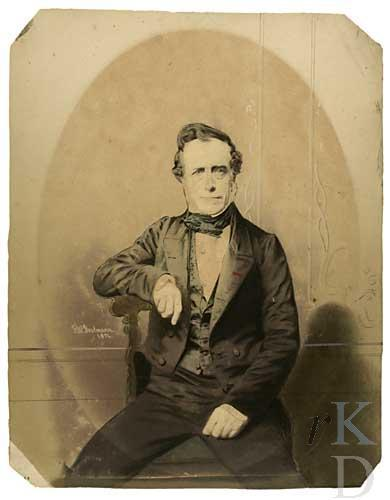

In [4]:
ds[0]['image']

### Formatting the Dataset for TRL

As we can see in the [TRL docs](https://huggingface.co/docs/trl/en/dataset_formats#vision-datasets) for using TRL with VLMs we need a dataset with a column of images (formated as a list of images) and a column containing messages, i.e. something like this

```
image column: List[Image]
text scolumn: [
  {
    "content": [
      {
        "text": null,
        "type": "image"
      },
      {
        "text": "Please describe this artwork thoroughly.",
        "type": "text"
      }
    ],
    "role": "user"
  }
]
```

We'll see how to format our dataset accordingly in the next section so this should become clearer!

::: {.callout-tip}
For this particular dataset I double check that the images are RGB and not too big. This isn't always required but since GLAM (Galleries, Libraries, Archives, and Museums) datasets can contain very large images/ a lot of black and white images, I do it here as an extra precaution!
:::

In [7]:
#| code-fold: true
#| code-summary: "Show pre processing code"
def ensure_rgb(example):
    """Ensure image is RGB"""
    if example['image'].mode != 'RGB':
        example['image'] = example['image'].convert('RGB')
    return example

def ensure_size(example, max_size):
    """Resize to max_size on one edge keeping aspect ratio correct"""
    image = example['image']
    w, h = image.size
    if max(w, h) > max_size:
        scale = max_size / float(max(w, h))
        new_size = (int(w * scale), int(h * scale))
        image = image.resize(new_size, Image.LANCZOS)
    example['image'] = image
    return example

ds = ds.map(ensure_rgb, num_proc=4)

Map (num_proc=4):   0%|          | 0/87744 [00:00<?, ? examples/s]

We need to convert our dataset to the messages format. We can do this using the `datasets` library's `map` function to transform each example in the dataset. We'll create a `format_as_messages` function to handle the conversion for each example.

In this particular example I want the VLM to output JSON containing a key `iconclass-codes` with a list/array of iconclass codes so we use `json.dumps` to format a dictionary into a JSON string we can include in the messages as the assistant's response.

In [8]:
from typing import Dict, Any
import json


def format_as_messages(
    example: Dict[str, Any], prompt: str | None = None
) -> Dict[str, Any]:
    """Format single example into messages format for TRL."""
    if not prompt:
        prompt = "What is in this image?"
    labels = example["label"]
    response = {"iconclass-codes": labels}
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": json.dumps(response)}],
        },
    ]

    return {
        "images": [example["image"]],  # List with single image
        "messages": messages,
    }

::: {.callout-tip}
It might seem a bit weird that we pass images to a list in this case but this is done so we can also support datasets where multiple images are included in a message(s).
:::

We can now apply the `format_as_messages` function to our dataset using the `map` function. We'll use a simple prompt for the VLM to follow.

In [9]:
ds = ds.map(
    format_as_messages,
    remove_columns=["image", "label"],
    num_proc=6,
    fn_kwargs={"prompt": "Extract ICONCLASS labels for this image."},
)

Map (num_proc=6):   0%|          | 0/87744 [00:00<?, ? examples/s]

Let's take a look at the dataset after formatting:


In [12]:
ds[0]

{'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=390x500>],
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'Extract ICONCLASS labels for this image.', 'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': '{"iconclass-codes": ["31A235", "31A24(+1)", "61B(+54)", "61B:31A2212(+1)", "61B:31D14"]}',
     'type': 'text'}],
   'role': 'assistant'}]}

We now split the dataset into train, validation, and test sets. For reasons that will become clearer in a future blog post we actually want to keep quite a bit of data back for later work so we'll define these splits a bit more manually than usual!

In [14]:
from datasets import DatasetDict

# Step 1: Split off 5% for test
split = ds.train_test_split(test_size=0.05, seed=42)
train_valid = split["train"]
test_ds = split["test"]

# Step 2: Split the remaining 95% into train and valid
train_valid_split = train_valid.train_test_split(test_size=0.4737, seed=42)
train_ds = train_valid_split["train"]
valid_ds = train_valid_split["test"]

# Combine into a DatasetDict

ds = DatasetDict({"train": train_ds, "valid": valid_ds, "test": test_ds})

In [15]:
ds

DatasetDict({
    train: Dataset({
        features: ['images', 'messages'],
        num_rows: 43870
    })
    valid: Dataset({
        features: ['images', 'messages'],
        num_rows: 39486
    })
    test: Dataset({
        features: ['images', 'messages'],
        num_rows: 4388
    })
})

### Push to Hub
We'll now push the dataset to the Hugging Face Hub so that it's easily accessible for others (and for us in the future!). We'll first use `flatten_indices` since we did quite a few transformations on the dataset.


In [16]:
ds = ds.flatten_indices()
ds.push_to_hub("davanstrien/iconclass-vlm-sft")

Flattening the indices:   0%|          | 0/43870 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/39486 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/4388 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ? shards/s]

Map:   0%|          | 0/10968 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  16%|#6        | 79.7MB /  489MB            

Map:   0%|          | 0/10968 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  23%|##2       |  110MB /  483MB            

Map:   0%|          | 0/10967 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  11%|#         | 52.5MB /  488MB            

Map:   0%|          | 0/10967 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  27%|##6       |  130MB /  488MB            

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ? shards/s]

Map:   0%|          | 0/9872 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/99 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  27%|##7       |  119MB /  439MB            

Map:   0%|          | 0/9872 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/99 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  17%|#7        | 77.3MB /  442MB            

Map:   0%|          | 0/9871 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/99 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  20%|##        | 87.5MB /  437MB            

Map:   0%|          | 0/9871 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/99 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   9%|8         | 38.9MB /  433MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/4388 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/44 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  69%|######8   |  131MB /  191MB            

README.md:   0%|          | 0.00/724 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/davanstrien/iconclass-vlm-sft/commit/d8d2cfe679ba89346920a894c8f7d134965a43a5', commit_message='Upload dataset', commit_description='', oid='d8d2cfe679ba89346920a894c8f7d134965a43a5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/davanstrien/iconclass-vlm-sft', endpoint='https://huggingface.co', repo_type='dataset', repo_id='davanstrien/iconclass-vlm-sft'), pr_revision=None, pr_num=None)

## HF Jobs x UV x TRL!

Hugging Face Jobs allows you to run code on Hugging Face Infrastructure including GPUs. Jobs can be run using either the `huggingface_hub` libraries CLI interface or via the Python API. A hello world example looks like this

In [33]:
!hf jobs run python:3.12 python -c "print('Hello world!')"

Job started with ID: 68b86a53e824c700d00ad361
View at: https://huggingface.co/jobs/davanstrien/68b86a53e824c700d00ad361
Hello world!


Jobs have an experimental `uv run` api that allow you to run uv scripts using Jobs. UV scripts are Python scripts that include their dependencies directly in the file using a special comment syntax. This makes them perfect for self-contained tasks that don’t require complex project setups. This works super well for use cases like a TRL training script! 

Let's take a look at the script we'll be running.

### The TRL SFT training script

You can find the full version of the script we're running in [main.py](https://raw.githubusercontent.com/davanstrien/blog/6da3910870f14a502626fd9c627da622e3122a3b/posts/2025/iconclass-vlm-sft/assets/main.py) but we can also see the most important parts below.

In [ ]:
#| code-fold: true
#| code-summary: "Show main.py training script"
import torch
from datasets import load_dataset
from transformers import AutoModelForImageTextToText

from trl import (
    ModelConfig,
    ScriptArguments,
    SFTConfig,
    SFTTrainer,
    TrlParser,
    get_kbit_device_map,
    get_peft_config,
    get_quantization_config,
)


if __name__ == "__main__":
    parser = TrlParser((ScriptArguments, SFTConfig, ModelConfig))
    script_args, training_args, model_args = parser.parse_args_and_config()
    training_args.gradient_checkpointing_kwargs = dict(use_reentrant=False)
    training_args.max_length = None

    ################
    # Model, Tokenizer & Processor
    ################
    torch_dtype = (
        model_args.torch_dtype if model_args.torch_dtype in ["auto", None] else getattr(torch, model_args.torch_dtype)
    )
    quantization_config = get_quantization_config(model_args)
    model_kwargs = dict(
        revision=model_args.model_revision,
        attn_implementation=model_args.attn_implementation,
        torch_dtype=torch_dtype,
        device_map=get_kbit_device_map() if quantization_config is not None else None,
        quantization_config=quantization_config,
    )

    model = AutoModelForImageTextToText.from_pretrained(
        model_args.model_name_or_path, trust_remote_code=model_args.trust_remote_code, **model_kwargs
    )

    ################
    # Dataset
    ################
    dataset = load_dataset(script_args.dataset_name, name=script_args.dataset_config)

    ################
    # Training
    ################
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset[script_args.dataset_train_split],
        eval_dataset=dataset[script_args.dataset_test_split] if training_args.eval_strategy != "no" else None,
        peft_config=get_peft_config(model_args),
    )

    trainer.train()

    # Save and push to hub
    trainer.save_model(training_args.output_dir)
    if training_args.push_to_hub:
        trainer.push_to_hub(dataset_name=script_args.dataset_name)

The training script looks as you'd expect a TRL script to look. One addition in the full script is inline script metadata for the dependencies. This let's `uv` know which libraries to install (we'll see another way we can specify dependencies later).

```
# /// script
# dependencies = [
#     "trl",
#     "Pillow>=9.4.0",
# ]
# ///
```

### Running uv Jobs using huggingface_hub

We can use the `huggingface_hub` library to easily manage and run our jobs on the Hugging Face platform. We'll grab our Hugging Face token from an `.env` file using `python-dotenv`. If you are running this notebook somewhere else you could also set the `HF_TOKEN` environment variable manually. 

In [19]:
from dotenv import load_dotenv
import os

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
assert HF_TOKEN

We then create a new `HfApi` instance.

In [20]:
from huggingface_hub import HfApi

api = HfApi(token=HF_TOKEN)

#### Model and dataset configuration

The easiest way to know the options our script supports would be to check the script but if we wanted we could also use hf jobs to print out the `--help` for the script. We can do this using the `uv run` subcommand:

In [ ]:
# | output: false
!hf jobs uv run "https://gist.githubusercontent.com/davanstrien/26a301d5a810746128a27b8ae49d0950/raw/141883e6ba4f5b51bc22de49e761a03564364fc5/main.py" --help

/Users/davanstrien/Library/Application Support/uv/tools/huggingface-hub/lib/python3.13/site-packages/huggingface_hub/utils/_experimental.py:60: UserWarning: 'HfApi.run_uv_job' is experimental and might be subject to breaking changes in the future without prior notice. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
Job started with ID: 68b86a90e824c700d00ad362
View at: https://huggingface.co/jobs/davanstrien/68b86a90e824c700d00ad362
Installed 62 packages in 268ms
usage: mainJNdAgg.py [-h] [--dataset_name DATASET_NAME]
                     [--dataset_config DATASET_CONFIG]
                     [--dataset_train_split DATASET_TRAIN_SPLIT]
                     [--dataset_test_split DATASET_TEST_SPLIT]
                     [--dataset_streaming [DATASET_STREAMING]]
                     [--gradient_checkpointing_use_reentrant [GRADIENT_CHECKPOINTING_USE_REENTRANT]]
                     [--ignore_bias_buffers [IGNORE_BIA

If you run this you'll see uv installing the required dependencies for your script (in this case `trl` + `Pillow`) and then returning the available options for the script. 

Since we may want to change options later we'll define some variables to hold our configuration. 

The main ones to note are the dataset, model and output model which refer to the dataset we want to use for training, the pre-trained model we want to fine-tune, and the output repo on the Hub where we want to save our model checkpoints respectively.

In [ ]:
DATASET = "davanstrien/iconclass-vlm-sft"
MODEL = "Qwen/Qwen2.5-VL-3B-Instruct"
MODEL = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"
OUTPUT_MODEL = "davanstrien/iconclass-vlm"
# Training hyperparameters
BATCH_SIZE = 10
GRADIENT_ACCUMULATION = 8
MAX_STEPS = None  # Adjust for full training
LEARNING_RATE = "2e-5"
EPOCHS = 1

We can then create a list to hold our script arguments that will be passed to the `trl` SFT fine-tuning script. 

In [ ]:
# use epochs if MAX_STEPS is None
if MAX_STEPS is None:
    MAX_STEPS = EPOCHS * (len(ds["train"]) // BATCH_SIZE // GRADIENT_ACCUMULATION)

# Build the script arguments
script_args = [
    "--model_name_or_path",
    MODEL,
    "--dataset_name",
    DATASET,
    "--output_dir",
    "./iconclass-vlm-outputs",
    "--hub_model_id",
    OUTPUT_MODEL,
    "--push_to_hub",
    "--per_device_train_batch_size",
    str(BATCH_SIZE),
    "--gradient_accumulation_steps",
    str(GRADIENT_ACCUMULATION),
    "--max_steps",
    str(MAX_STEPS),
    "--torch_dtype",
    "bfloat16",
    "--logging_steps",
    "10",
    "--save_steps",
    "100",
    "--eval_steps",
    "100",
    "--warmup_ratio",
    "0.1",
    "--learning_rate",
    LEARNING_RATE,
    "--attn_implementation",
    "kernels-community/flash-attn",
]


We now have our arguments ready to be passed to the `trl` SFT fine-tuning script. To actually run the script we can use the `run_uv_job` method. 

We'll pass a few things to this.

- `script`: the URL or path to the `trl` SFT fine-tuning script.
- `script_args`: the arguments to pass to the script.
- `dependencies`: any additional dependencies required by the script.
- `flavor`: the type of hardware to use i.e. `a100-large`
- `image`: the docker image to use for the job.
- `timeout`: the maximum time to allow the job to run.
- `env`: any environment variables to set for the job.
- `secrets`: any secrets required by the job.



In [61]:
TRACKIO_PROJECT="iconclass"
TRACKIO_SPACE_ID="trackio-trl"

In [ ]:
# Submit the job using run_uv_job
job = api.run_uv_job(
    script="https://gist.githubusercontent.com/davanstrien/26a301d5a810746128a27b8ae49d0950/raw/141883e6ba4f5b51bc22de49e761a03564364fc5/main.py",
    script_args=script_args,
    dependencies=[
        "torchvision",
        "tensorboard",
        "accelerate",
        "wandb",
        "kernels",
        "trackio",
    ],
    flavor="a100-large",
    image="vllm/vllm-openai:latest",
    timeout="12h",  # Adjust based on MAX_STEPS
    env={"TRACKIO_PROJECT": TRACKIO_PROJECT, "TRACKIO_SPACE_ID": TRACKIO_SPACE_ID},
    secrets={
        "HF_TOKEN": os.environ.get("HF_TOKEN"),
        "WANDB_API_KEY": os.environ.get("WANDB_API_KEY"),
    },
)


/Users/davanstrien/Documents/daniel/blog/.venv/lib/python3.12/site-packages/huggingface_hub/utils/_experimental.py:60: UserWarning: 'HfApi.run_uv_job' is experimental and might be subject to breaking changes in the future without prior notice. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(


In [66]:
job.status

JobStatus(stage='RUNNING', message=None)

In [67]:
job.url

'https://huggingface.co/jobs/davanstrien/68b9c334d797b777b755e63b'

## Evaluating the model's performance so far

<iframe
	src="https://davanstrien-iconclass-predictions.static.hf.space"
	frameborder="0"
	width="850"
	height="450"
></iframe>




[^1]: [Iconclass. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/Iconclass](https://iconclass.org/help/about)